In [44]:
import pandas as pd

def load_and_combine_surveys(path_2015: str, path_2023: str) -> pd.DataFrame:
    """Load and tag 2015 & 2023 survey CSVs."""
    df15 = pd.read_csv(path_2015)
    df15['year'] = '2015'
    df23 = pd.read_csv(path_2023)
    df23['year'] = '2023'
    return pd.concat([df15, df23], ignore_index=True)

def print_unique_measures(path_2015: str, path_2023: str):
    """
    Print unique 'measure' values for 2015 and 2023,
    and the intersection of both.
    """
    df = load_and_combine_surveys(path_2015, path_2023)
    measures_2015 = set(df[df['year'] == '2015']['measure'].dropna().unique())
    measures_2023 = set(df[df['year'] == '2023']['measure'].dropna().unique())
    
    common = measures_2015.intersection(measures_2023)
    
    print("=== Unique 'measure' values in 2015 survey ===")
    for m in sorted(measures_2015):
        print("-", m)
        
    print("\n=== Unique 'measure' values in 2023 survey ===")
    for m in sorted(measures_2023):
        print("-", m)

# Example usage
print_unique_measures(
    './Transformed_MBTA_2015_System-Wide_Passenger_Survey_Data.csv',
    './MBTA_2023_System-Wide_Passenger_Survey_Data.csv'
)


=== Unique 'measure' values in 2015 survey ===
- Ability to understand English
- Access to first MBTA service
- Age
- Alternative modes
- Fare
- Gender
- Hispanic or Latino/Latina
- Household income
- Low-income classification
- Minority classification
- Monthly pass type
- Pay-per-ride type
- Previous transit mode
- Race
- Trip frequency
- Trip purpose
- Usable household vehicles
- Use alternative modes
- Valid driver's license
- Vehicles per capita

=== Unique 'measure' values in 2023 survey ===
- Ability to Understand English
- Access to First MBTA Service
- Age
- Alternative Mode
- Cars per Capita
- Fare Product
- Frequency
- Gender
- Hispanic or Latino/Latina
- Household Income
- Race
- Reduced Fares
- Title VI Low-Income
- Title VI Minority
- Trip Purpose
- Usable Cars
- Used Alternative Mode


In [45]:
import pandas as pd
import re

def load_and_normalize(path):
    """
    Load a survey CSV and add a 'measure_norm' column which is:
      - lowercase
      - stripped of leading/trailing whitespace
      - stripped of punctuation
    """
    df = pd.read_csv(path)
    df['measure_norm'] = (
        df['measure']
        .astype(str)
        .str.lower()
        .str.strip()
        .str.replace(r'[^a-z0-9 ]', '', regex=True)
    )
    return df

def find_common_measures(path_2015, path_2023):
    # load & normalize each
    df15 = load_and_normalize(path_2015)
    df23 = load_and_normalize(path_2023)
    
    # build sets of unique normalized measures
    set15 = set(df15['measure_norm'].unique())
    set23 = set(df23['measure_norm'].unique())
    
    # find common names
    common = sorted(set15 & set23)
    return common

# ——— Usage ———
common_measures = find_common_measures(
    './Transformed_MBTA_2015_System-Wide_Passenger_Survey_Data.csv',
    './MBTA_2023_System-Wide_Passenger_Survey_Data.csv'
)
print("Measures present in both years:\n", "\n".join(common_measures))


Measures present in both years:
 ability to understand english
access to first mbta service
age
gender
hispanic or latinolatina
household income
race
trip purpose


In [46]:
important_routes = [ '22', '29', '15', '45', '44', '42', '17', '23', '31', '26', '111', '24', '33', '14']

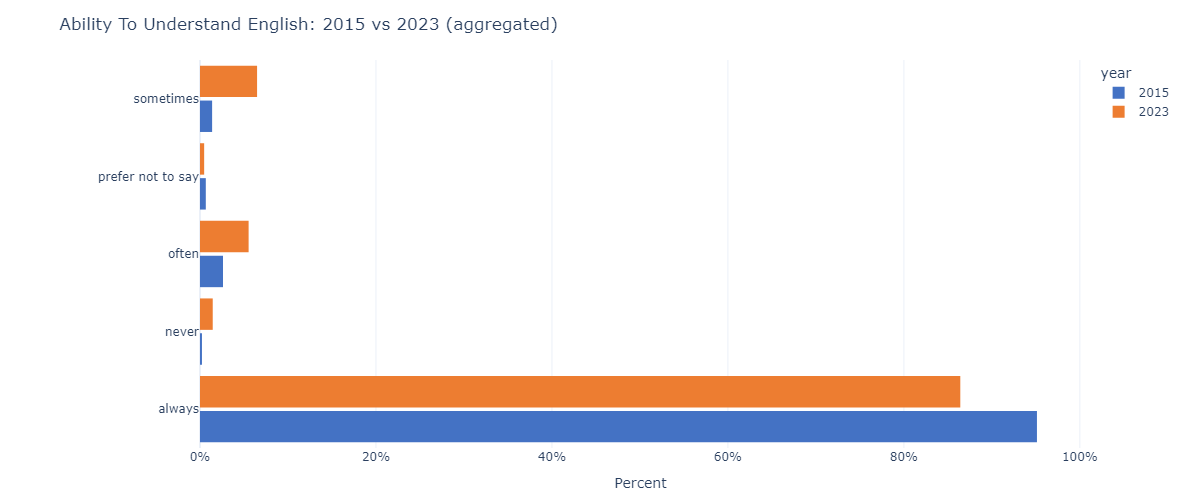

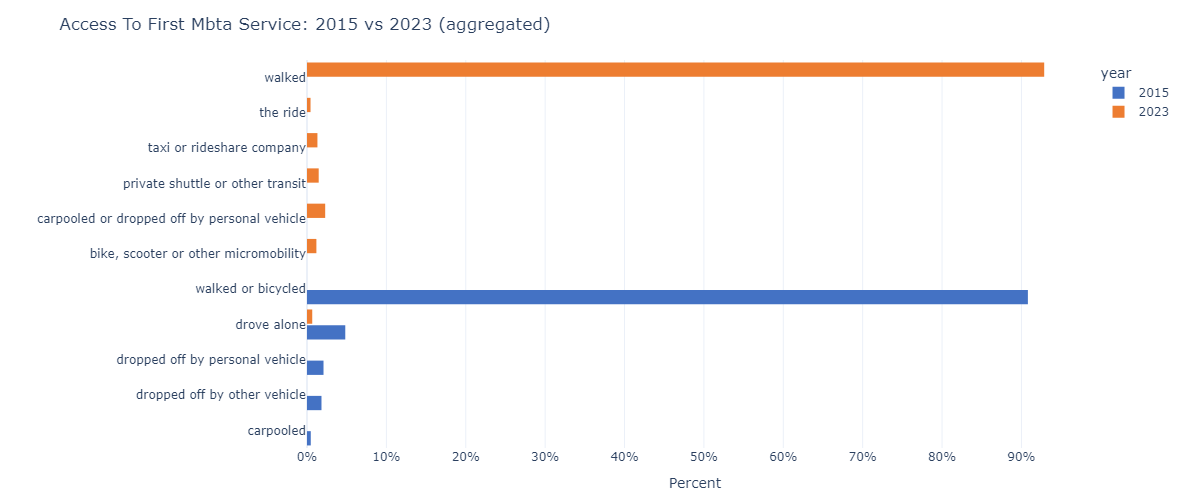

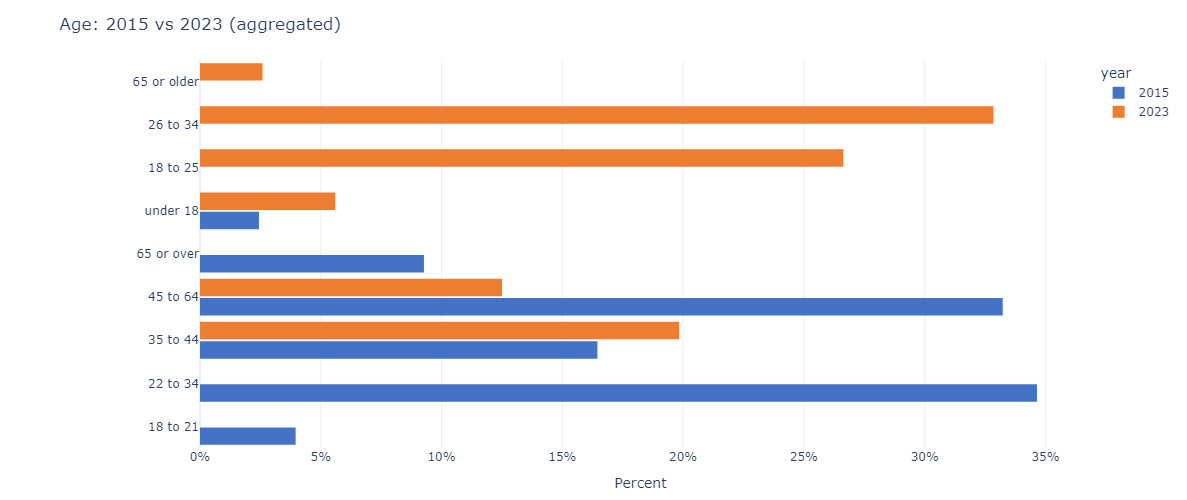

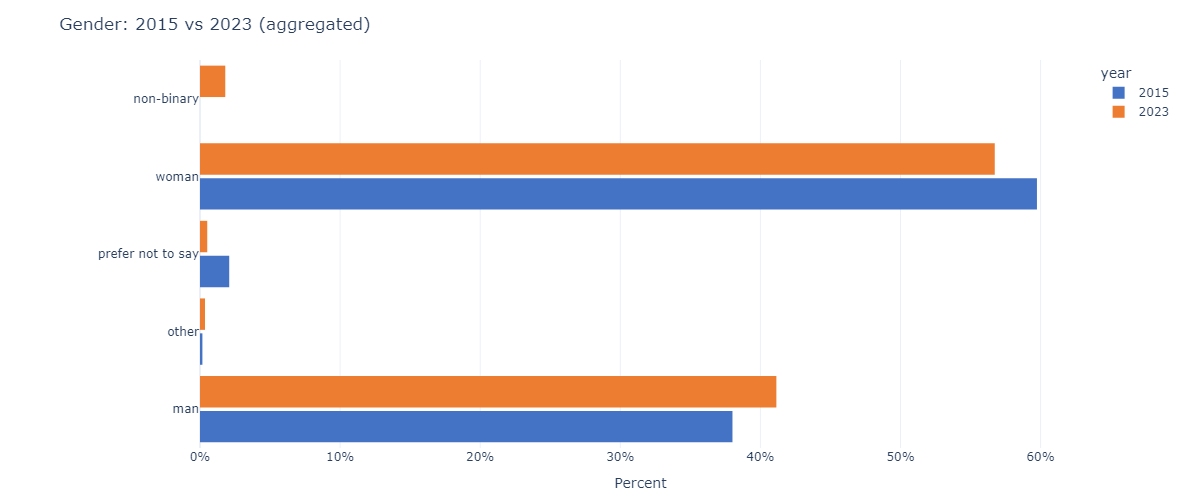

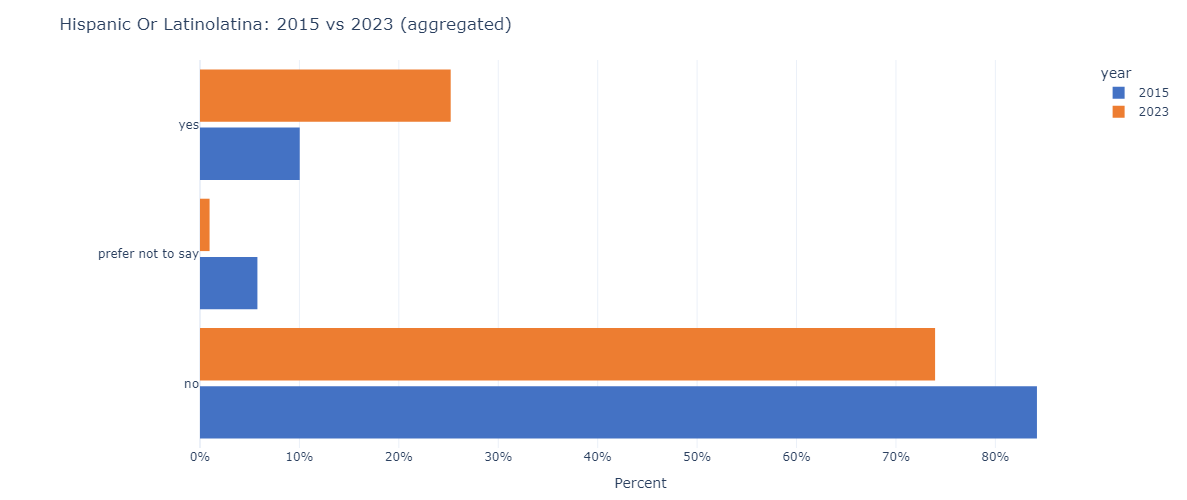

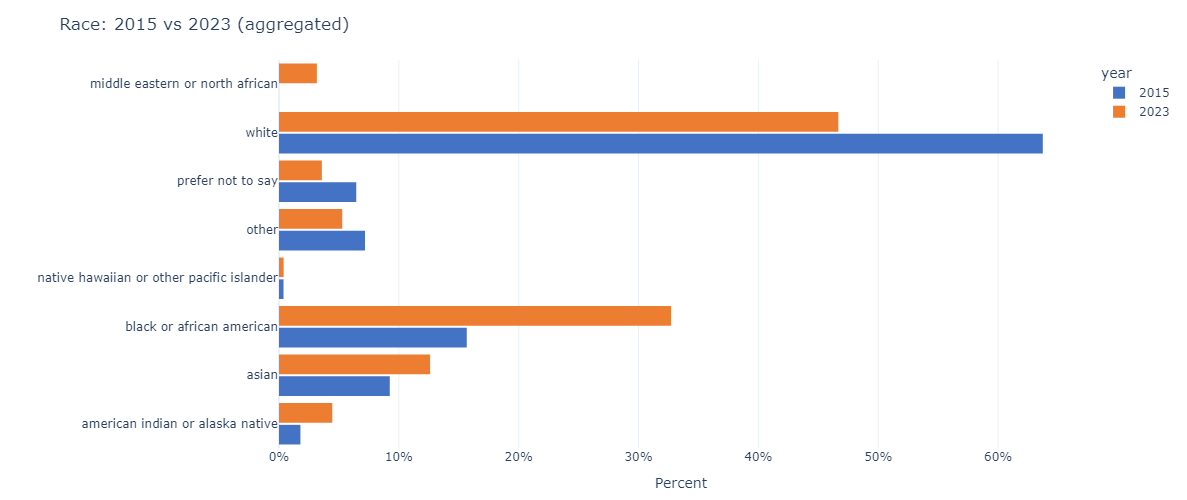

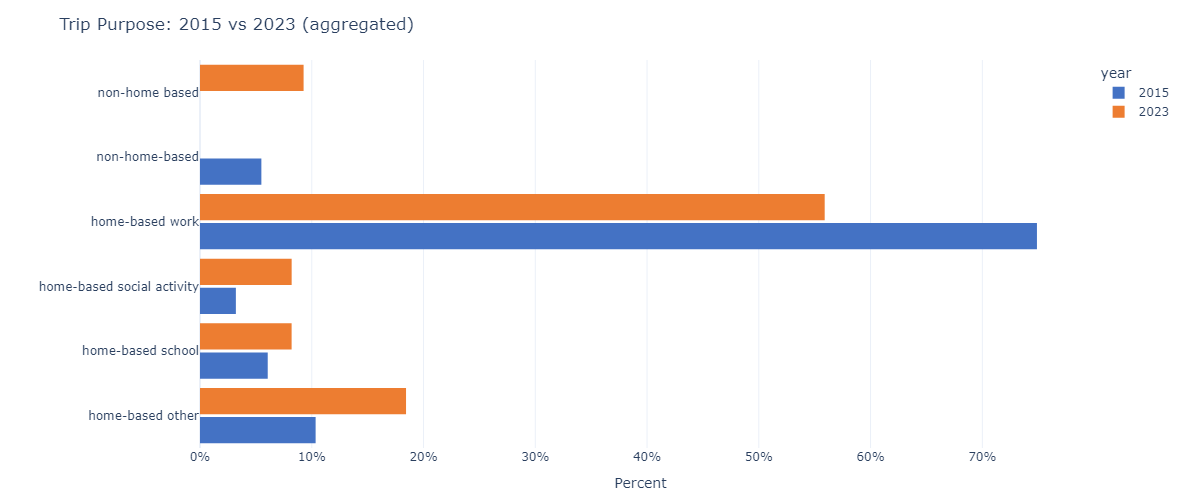

In [49]:
import pandas as pd
import plotly.express as px

def load_and_tag(path: str, year: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df['year'] = year
    # normalize measure for matching
    df['measure_norm'] = (
        df['measure']
          .str.lower().str.strip()
          .str.replace(r'[^a-z0-9 ]', '', regex=True)
    )
    df['category'] = df['category'].str.lower().str.strip()
    return df

def aggregate_over_reporting(df: pd.DataFrame) -> pd.DataFrame:
    """
    Collapse out reporting_group by averaging weighted_percent
    for each (year, measure_norm, category).
    """
    return (
        df
        .groupby(['year','measure_norm','category'], as_index=False)
        ['weighted_percent']
        .mean()
    )

def plot_two_bars_per_category(agg_df: pd.DataFrame, measure_norm: str,
                               width=800, height=500):
    """
    For the given measure_norm, draw exactly two bars per category:
    one for 2015, one for 2023.
    """
    sub = agg_df[agg_df['measure_norm']==measure_norm].copy()
    if sub.empty:
        print(f"No data for {measure_norm!r}")
        return

    # convert fraction → percent
    sub['pct'] = sub['weighted_percent'] * 100

    fig = px.bar(
        sub,
        x='pct',
        y='category',
        color='year',
        orientation='h',
        barmode='group',
        color_discrete_map={'2015':'#4472C4','2023':'#ED7D31'},
        labels={'pct':'Percent','category':''},
        title=f"{measure_norm.title()}: 2015 vs 2023 (aggregated)"
    )
    fig.update_traces(marker_line_width=0,
                      hovertemplate='%{y}<br>%{x:.1f}%')
    fig.update_layout(
        bargap=0.1,          # small gap between groups
        bargroupgap=0.1,     # small gap within group
        xaxis=dict(ticksuffix='%'),
        margin=dict(l=200,r=40,t=60,b=40),
        width=width, height=height,
        template='plotly_white'
    )
    fig.show()
    return fig

# ——— Usage ———

# 1) Load & tag both files
df15 = load_and_tag(
    './Transformed_MBTA_2015_System-Wide_Passenger_Survey_Data.csv',
    '2015'
)
df23 = load_and_tag(
    './MBTA_2023_System-Wide_Passenger_Survey_Data.csv',
    '2023'
)

# 2) Combine & aggregate
df_all = pd.concat([df15, df23], ignore_index=True)
agg = aggregate_over_reporting(df_all)

# 3) Plot—two bars per category
for measure in [
    'ability to understand english',
    'access to first mbta service',
    'age',
    'gender',
    'hispanic or latinolatina',
    'race',
    'trip purpose'
]:
    plot_two_bars_per_category(agg, measure)
